In [1]:
import pandas as pd # obliczenia
import numpy as np # obliczenia
import matplotlib.pyplot as plt # grafika
import seaborn as sns # grafika
import math
import csv
import re
import pickle
import time
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV,KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.linear_model import RidgeClassifier, SGDClassifier, Perceptron, PassiveAggressiveClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [119]:
# Wczytuję dane
abt = pd.read_csv('abt_app.csv', sep='\t')
# Usuwam niepotrzebne kolumny (podejrzane w skryptach z zajęć)
to_delete=['aid','cid','period','default3','default6','default9','default_cross6','default_cross9','default_cross12','default_cross3','cross_aid']
abt= abt.drop(to_delete,axis=1)
print(abt.shape)
abt.head()

(11437, 208)


,product,act_age,act_cc,act_loaninc,app_income,app_loan_amount,app_n_installments,app_number_of_children,app_spendings,app_installment,...,ags12_Min_CMaxA_Due,act12_n_arrears,act12_n_arrears_days,act12_n_good_days,decision,cross_response,cross_after_monhs,default12,cross_app_loan_amount,cross_app_n_installments
0,css,45.0,0.326905,1.530456,3267.0,5000.0,24.0,3.0,860.0,208.0,...,0.0,10.0,2.0,4.0,A,0.0,NaN,1.0,NaN,NaN
1,css,42.0,0.538908,2.903600,1722.0,5000.0,24.0,1.0,720.0,208.0,...,0.0,0.0,0.0,1.0,A,0.0,NaN,0.0,NaN,NaN
2,css,59.0,0.543742,3.364738,1486.0,5000.0,24.0,2.0,600.0,208.0,...,0.0,4.0,0.0,1.0,A,1.0,4.0,0.0,5000.0,24.0
3,css,63.0,0.587702,3.236246,1545.0,5000.0,24.0,0.0,700.0,208.0,...,0.0,3.0,0.0,4.0,A,0.0,NaN,0.0,NaN,NaN
4,css,48.0,0.436407,1.506932,3318.0,5000.0,24.0,2.0,1240.0,208.0,...,0.0,0.0,0.0,10.0,A,0.0,NaN,1.0,NaN,NaN


In [120]:
# Na samym początku usunę wiersze, gdzie 'default12' jest NA:
abt = abt[np.isfinite(abt['default12'])]

In [121]:
# Usunę wszystkie kolumny, w których mam ponad 2/3 wartości NA (wygodniejszy wariant od wyrzucania połowy :))
to_delete = abt.columns[abt.count()<len(abt)/1.5]
abt= abt.drop(to_delete,axis=1)
# Zostałem ze 141 kolumnami
abt.shape

(9861, 141)

In [182]:
# Następnie chcę wyrzucić kolumny posiadające (oprócz NA) tylko jedną wartość:
to_delete = []
for col in abt.columns:
    ile = len(abt[col].unique())
    # Odkomentuj w celu zobaczenia liczby różnych wartości w poszczególnych wierszach
#     print("{} - {}".format(col,ile))
    if ile == 1:
        to_delete.append(col)
        
abt = abt.drop(to_delete,axis=1)
# Pozbyłem się kolejnych paru kolumn, świetnie!
abt.shape

(9861, 133)

In [123]:
# Wynajduję dane nienumeryczne:

abt.dtypes[abt.dtypes != "float64"]
# abt.dtypes == 'float64'

# Podmieniam na dane numeryczne

abt.loc[abt['app_char_gender'] == 'Male', 'app_char_gender'] = 0
abt.loc[abt['app_char_gender'] == 'Female', 'app_char_gender'] = 1


abt.loc[abt['app_char_job_code'] == 'Contract', 'app_char_job_code'] = 0
abt.loc[abt['app_char_job_code'] == 'Owner company', 'app_char_job_code'] = 1
abt.loc[abt['app_char_job_code'] == 'Permanent', 'app_char_job_code'] = 2
abt.loc[abt['app_char_job_code'] == 'Retired', 'app_char_job_code'] = 3


abt.loc[abt['app_char_marital_status'] == 'Divorced', 'app_char_marital_status'] = 0
abt.loc[abt['app_char_marital_status'] == 'Maried', 'app_char_marital_status'] = 1
abt.loc[abt['app_char_marital_status'] == 'Singiel', 'app_char_marital_status'] = 2
abt.loc[abt['app_char_marital_status'] == 'Widowed', 'app_char_marital_status'] = 3


abt.loc[abt['app_char_city'] == 'Big', 'app_char_city'] = 0
abt.loc[abt['app_char_city'] == 'Large', 'app_char_city'] = 1
abt.loc[abt['app_char_city'] == 'Medium', 'app_char_city'] = 2
abt.loc[abt['app_char_city'] == 'Small', 'app_char_city'] = 3


abt.loc[abt['app_char_home_status'] == 'Owner', 'app_char_home_status'] = 0
abt.loc[abt['app_char_home_status'] == 'Rental', 'app_char_home_status'] = 1
abt.loc[abt['app_char_home_status'] == 'With parents', 'app_char_home_status'] = 2


abt.loc[abt['app_char_cars'] == 'No', 'app_char_cars'] = 0
abt.loc[abt['app_char_cars'] == 'Owner', 'app_char_cars'] = 1

In [124]:
# Pozostałe NA uzupełnię wartościami średnimi i zobaczę co powie klasyfikator:
abt = abt.fillna(abt.mean())

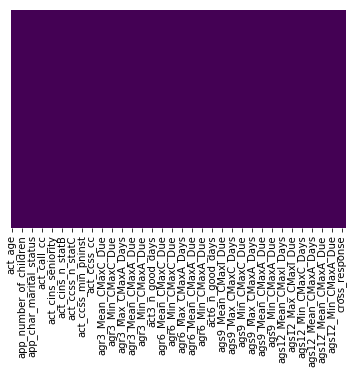

In [125]:
# Ruchomy wykres do graficznego sprawdzenia, gdzie się jeszcze kryją NA 
sns.heatmap(abt.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [126]:
# Wydzielę teraz target
target = abt['default12']
abt.drop('default12',axis=1,inplace=True)

In [ ]:
# Wyszukam parę dobrze działających klasyfikatorów oraz, oczywiście, sprawdzę jak działa VotingClassifier
clf1 = RidgeClassifier()
clf2 = ExtraTreesClassifier(n_estimators=12,criterion='gini')
clf3 = AdaBoostClassifier()
# clf4 = MLPClassifier(hidden_layer_sizes=(7,))
list = [
    clf1,
    clf2,
    clf3,
    clf4
]
list_names = [
    'Rigde',
    'ExtraTrees',
    'ADA',
#     'MLP',
]
# Podzielę na zbiory treningowe i testowe, zapusczę cross validację
# Najwyższym wynikiem prawie 79% może się pochwalić Rigde oraz ExtraTrees oraz ADA
k = 10
# Set up classifiers, see if I can get something. I will derive some stuff later.
for clf, label in zip(list, list_names):
        # scores = cross_val_score(clf, x_tfidf, y, cv=8, scoring='accuracy', n_jobs=-1)
        # print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))
    pred = cross_val_predict(
            clf, abt,
            y=target,
            cv=k, n_jobs=-1, verbose=20
    )
    print(label)
    cm = confusion_matrix(target, pred)
    print(cm)
    accuracy = accuracy_score(target, pred)
    print(accuracy)

eclf = VotingClassifier(estimators=[(i, j) for i, j in zip(list_names, list)], voting='hard')
pred = cross_val_predict(
            eclf, abt, y=target, cv=k, n_jobs=-1, verbose=20
        )
print("VOTING CLASSIFIER hard")
cr = classification_report(target, pred, target_names=['alive','dead'])
cm = confusion_matrix(target, pred)
accuracy = accuracy_score(target, pred)
# print(pred)
print(cr)
print(cm)
print(accuracy)

eclf = VotingClassifier(estimators=[(i, j) for i, j in zip(list_names, list)], voting='soft')
pred = cross_val_predict(
            eclf, abt, y=target, cv=k, n_jobs=-1, verbose=20
        )

# W celu odpalenie miekkiej wersji VotingClassifier musiałbym przekształcić RigdeClassifier używając 
# clf = CalibratedClassifierCV(RidgeClassifier())

# print("VOTING CLASSIFIER soft")
# cr = classification_report(target, pred, target_names=['alive','dead'])
# cm = confusion_matrix(target, pred)
# accuracy = accuracy_score(target, pred)
# # print(pred)
# print(cr)
# print(cm)
# print(accuracy)

In [178]:
# Ostatecznie wybieram RigdeClassifier (VotingClassifier w wersji hard jest także dobrym  wyborem). 
# Mógłbym jeszcze się pokusić o GridSearch w celu osiągnięcia 80%, jednak na razie zostawię projekt w obecnym kształcie:
clf = CalibratedClassifierCV(RidgeClassifier())
k = 10
pred = cross_val_predict(
        clf, abt,
        y=target,
        cv=k, n_jobs=-1, verbose=20
)
print("Confusion matrix:")
cm = confusion_matrix(target, pred)
print(cm)
accuracy = accuracy_score(target, pred)
print("Accuracy: {}".format(accuracy))


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    2.0s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    2.6s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    3.3s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    4.0s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.6s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    5.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    5.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.9s finished


Confusion matrix:
[[4082  943]
 [1130 3706]]
Accuracy: 0.7897779129905689
